In [809]:
# Importation 
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import os
import openpyxl
from tsfresh import extract_features, select_features
directory = os.getcwd()

# Pré-processing

In [810]:
# Importation données NDVI
donnees = pd.read_csv(f"{directory}/donnees/resultats-2.csv", sep = ";", parse_dates = ["date"], dayfirst = True)

# Typage des colonnes
donnees['parcelle'] = donnees['parcelle'].astype('string')
donnees["parcelle"] = donnees["parcelle"].map(lambda x:x.replace('_','').lower())
donnees.columns = donnees.columns.str.replace('NDVI_moy', 'ndvi')
donnees = donnees.set_index('date', drop = False)

donnees["campagne"] = donnees["date"].dt.year # on utilise cette colonne campagne pour les jointures pr récup le peuplement et le précédent
donnees['campagne'] = donnees['campagne'].astype('string')
print(donnees)

              parcelle       date  ndvi campagne
date                                            
2022-05-10         222 2022-05-10  3255     2022
2022-06-14         222 2022-06-14  7444     2022
2022-06-19         222 2022-06-19  6815     2022
2022-07-14         222 2022-07-14  5632     2022
2022-07-24         222 2022-07-24  4573     2022
...                ...        ...   ...      ...
2022-08-17  tivillers8 2022-08-17  2002     2022
2022-08-20  tivillers8 2022-08-20  2106     2022
2022-08-22  tivillers8 2022-08-22  1807     2022
2022-08-25  tivillers8 2022-08-25  1835     2022
2022-08-30  tivillers8 2022-08-30  2051     2022

[650 rows x 4 columns]


In [811]:
peuplement_1 = pd.read_excel(f"{directory}/donnees/peuplement/donnees2022_BA-2.xlsx", engine='openpyxl', parse_dates = ["date"])
peuplement_1 = peuplement_1.loc[:,["parcelle","date","peuplement"]]

peuplement_2 = pd.read_excel(f"{directory}/donnees/peuplement/Placette_TRN22_beauce.xlsx", engine='openpyxl', parse_dates = ["date_obs"])
peuplement_2 = peuplement_2.loc[:,["numero_parcelle","date_obs","peuplement"]]
peuplement_2.columns = peuplement_2.columns.str.replace('numero_parcelle', 'parcelle')
peuplement_2.columns = peuplement_2.columns.str.replace('date_obs','date')
peuplement_2 = peuplement_2[peuplement_2["parcelle"] != "80_22"] # la dernière ligne a un NA dans col peuplement

peuplement = peuplement_1.merge(peuplement_2)
peuplement = pd.concat([peuplement_1, peuplement_2], axis = 0, ignore_index = True)
peuplement["parcelle"] = peuplement["parcelle"].map(lambda x:x.replace('_','').lower())
peuplement['parcelle'] = peuplement['parcelle'].astype('string')
peuplement = peuplement.groupby(["parcelle"]).agg({"date":["first"], "peuplement":["mean"]})
peuplement.columns = peuplement.columns.droplevel()
peuplement.columns = ["date","peuplement"]
peuplement = peuplement.reset_index()

# Intégration aux données NDVI
peuplement["campagne"] = peuplement["date"].dt.year.map(lambda x:int(x))
peuplement['campagne'] = peuplement['campagne'].astype('string')
peuplement = peuplement.drop(["date"], axis = 1)

donnees = donnees.merge(peuplement,on=['campagne','parcelle'],how='left')

donnees['parcelle'] = donnees['parcelle'].astype('string')
print(donnees)
#donnees = donnees[donnees["parcelle"] == "tivillers8"]
#donnees["ndvi"].plot(title = "Evolution du NDVI sur l'année", ylabel = "NDVI")
#donnees["ndvi"].resample("2W").mean().plot(title = "Evolution du NDVI sur l'année", ylabel = "NDVI")

       parcelle       date  ndvi campagne  peuplement
0           222 2022-05-10  3255     2022         NaN
1           222 2022-06-14  7444     2022         NaN
2           222 2022-06-19  6815     2022         NaN
3           222 2022-07-14  5632     2022         NaN
4           222 2022-07-24  4573     2022         NaN
..          ...        ...   ...      ...         ...
645  tivillers8 2022-08-17  2002     2022     82000.0
646  tivillers8 2022-08-20  2106     2022     82000.0
647  tivillers8 2022-08-22  1807     2022     82000.0
648  tivillers8 2022-08-25  1835     2022     82000.0
649  tivillers8 2022-08-30  2051     2022     82000.0

[650 rows x 5 columns]


In [812]:
donnees = donnees.sort_values(["parcelle","date"])
donnees = donnees.dropna(axis = 0, subset=['peuplement'])

df = donnees.loc[:,["parcelle","date","ndvi"]]
y = donnees.loc[:,["parcelle","peuplement","campagne"]].drop_duplicates().peuplement

y = y.reset_index(drop = True)
df = df.reset_index(drop = True)

In [813]:
print(df)

       parcelle       date  ndvi
0          1722 2022-05-10  3606
1          1722 2022-05-30  7392
2          1722 2022-06-14  7679
3          1722 2022-06-19  7855
4          1722 2022-07-14  4981
..          ...        ...   ...
607  tivillers8 2022-08-17  2002
608  tivillers8 2022-08-20  2106
609  tivillers8 2022-08-22  1807
610  tivillers8 2022-08-25  1835
611  tivillers8 2022-08-30  2051

[612 rows x 3 columns]


In [814]:
print(y)

0     56000.000000
1     75600.000000
2     68000.000000
3     71600.000000
4     43600.000000
5     67200.000000
6     68000.000000
7     57600.000000
8     64400.000000
9     56000.000000
10    56000.000000
11    58800.000000
12    54800.000000
13    50400.000000
14    52000.000000
15    41200.000000
16    33200.000000
17    56800.000000
18    61600.000000
19    62000.000000
20    30000.000000
21    39200.000000
22    48400.000000
23    36416.666667
24    30000.000001
25    60555.555555
26    37666.666668
27    49333.333334
28    29090.909090
29    38181.818182
30    45454.545456
31    43666.666666
32    36952.380952
33    35166.666667
34    30222.222222
35    38000.000000
36    41200.000000
37    79600.000000
38    72000.000000
39    94000.000000
40    82000.000000
Name: peuplement, dtype: float64


In [815]:
# Lecture de csv résultant 
df_doy = pd.read_csv(f"{directory}/df.csv", sep = ";")
print(df_doy)


       parcelle  date  ndvi
0          1722   129  3606
1          1722   149  7392
2          1722   164  7679
3          1722   169  7855
4          1722   194  4981
..          ...   ...   ...
607  tivillers8   228  2002
608  tivillers8   231  2106
609  tivillers8   233  1807
610  tivillers8   236  1835
611  tivillers8   241  2051

[612 rows x 3 columns]


In [816]:
# Stockage des données ndvi et leur index en jour de l'année associé dans une liste de liste 
parcelle_nb = df["parcelle"].drop_duplicates().values.tolist()
print(parcelle_nb)
groups = df_doy.groupby(['parcelle'])
doy_ndvi = []
for name in parcelle_nb : 
    doy_ndvi.append([groups.get_group(name)['date'].values.tolist(),groups.get_group(name)['ndvi'].values.tolist()])
print(doy_ndvi[:10])

['1722', '2822', '2922', '3822', '4222', '4422', '4522', '4722', '5222', '5322', '5422', '6222', '6322', '6622', '6722', '7122', '7322', '7422', '7522', '7622', '7822', '8222', '8822', 'aubiet11', 'aubiet22', 'coulonges2', 'fdgeda1', 'fdgeda2', 'fdgeda6', 'fdgeda7', 'fdgeda8', 'lamagistere3', 'tiagen1', 'tiravard1', 'tirosieres1', 'tirosieres3', 'tirosieres4', 'tivillers5', 'tivillers6', 'tivillers7', 'tivillers8']
[[[129, 149, 164, 169, 194, 204, 214, 219, 224], [3606, 7392, 7679, 7855, 4981, 6421, 4475, 3795, 3458]], [[129, 149, 164, 169, 194, 204, 214, 219, 224], [2808, 7321, 6390, 7689, 4915, 4632, 3579, 3426, 3103]], [[99, 129, 149, 164, 169, 194, 204, 214, 219, 224], [1633, 2381, 7082, 6419, 7486, 4967, 4808, 3219, 2991, 2685]], [[99, 129, 149, 164, 169, 194, 204, 214, 219, 224], [1479, 1673, 7711, 7945, 8177, 6858, 7747, 4773, 3448, 3650]], [[99, 129, 149, 164, 169, 194, 204, 214, 219, 224, 239], [2231, 3310, 5527, 7316, 7164, 6658, 7114, 5303, 3939, 3058, 2344]], [[99, 129, 149

In [817]:
#Pour que tous les index commencent à 0
doy0_ndvi = []
for parc in doy_ndvi : 
    new_doy = []
    for day in parc[0]:
        new_doy.append(day-parc[0][0])
    doy0_ndvi.append([new_doy,parc[1]])
print(doy0_ndvi[:10])

[[[0, 20, 35, 40, 65, 75, 85, 90, 95], [3606, 7392, 7679, 7855, 4981, 6421, 4475, 3795, 3458]], [[0, 20, 35, 40, 65, 75, 85, 90, 95], [2808, 7321, 6390, 7689, 4915, 4632, 3579, 3426, 3103]], [[0, 30, 50, 65, 70, 95, 105, 115, 120, 125], [1633, 2381, 7082, 6419, 7486, 4967, 4808, 3219, 2991, 2685]], [[0, 30, 50, 65, 70, 95, 105, 115, 120, 125], [1479, 1673, 7711, 7945, 8177, 6858, 7747, 4773, 3448, 3650]], [[0, 30, 50, 65, 70, 95, 105, 115, 120, 125, 140], [2231, 3310, 5527, 7316, 7164, 6658, 7114, 5303, 3939, 3058, 2344]], [[0, 30, 50, 65, 70, 95, 105, 115, 120, 125], [2235, 4586, 7896, 7891, 7848, 5548, 7146, 5333, 4716, 4389]], [[0, 30, 50, 65, 70, 95, 105, 115, 120, 125], [8680, 5639, 8423, 7026, 5228, 2112, 1837, 1461, 1578, 1523]], [[0, 30, 50, 65, 70, 95, 105, 115, 120, 125], [2248, 4204, 6281, 7485, 7354, 5894, 6770, 4782, 3872, 3347]], [[0, 30, 50, 65, 70, 95, 105, 115, 120, 125], [7685, 6232, 7676, 6747, 5432, 2857, 2129, 2832, 3387, 3122]], [[0, 20, 35, 38, 40, 53, 63, 65, 68

In [818]:
# On ajoute les valeurs manquante avec des NA
doy_NA = []
for parc in doy_ndvi : 
    indice = []
    val = []
    ind2 = 0
    for i in range(int((parc[0][-1]-parc[0][0])/5)) : 
        if i*5 + parc[0][0] in parc[0]:
            indice.append(i*5+ parc[0][0])
            val.append(parc[1][ind2])
            ind2 += 1
        else : 
            indice.append(i*5+ parc[0][0])
            val.append(np.nan)
    doy_NA.append([indice,val])
print(doy_NA[:10])


[[[129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219], [3606, nan, nan, nan, 7392, nan, nan, 7679, 7855, nan, nan, nan, nan, 4981, nan, 6421, nan, 4475, 3795]], [[129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219], [2808, nan, nan, nan, 7321, nan, nan, 6390, 7689, nan, nan, nan, nan, 4915, nan, 4632, nan, 3579, 3426]], [[99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219], [1633, nan, nan, nan, nan, nan, 2381, nan, nan, nan, 7082, nan, nan, 6419, 7486, nan, nan, nan, nan, 4967, nan, 4808, nan, 3219, 2991]], [[99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219], [1479, nan, nan, nan, nan, nan, 1673, nan, nan, nan, 7711, nan, nan, 7945, 8177, nan, nan, nan, nan, 6858, nan, 7747, nan, 4773, 3448]], [[99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 15

In [819]:
#création des tailles des listes de ndvi 
le=[]
print (len(doy_NA))
for i in range (len(doy_NA)):
    for j in range (len(doy_NA[i])):
        le.append(len(doy_NA[i][j]))

print (le)


41
[19, 19, 19, 19, 25, 25, 25, 25, 28, 28, 25, 25, 25, 25, 25, 25, 25, 25, 22, 22, 28, 28, 25, 25, 25, 25, 28, 28, 25, 25, 25, 25, 25, 25, 25, 25, 28, 28, 28, 28, 28, 28, 25, 25, 25, 25, 29, 29, 29, 29, 22, 22, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 20, 20, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29]


In [820]:
print (len(doy_NA))
for i in range (len (doy_NA)):
    print(doy_NA[i][0])

41
[129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219]
[129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219]
[99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219]
[99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219]
[99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219, 224, 229, 234]
[99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219]
[99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219]
[99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219]
[99, 104, 109, 114, 119, 124, 129, 134, 

In [821]:
new_doy_NA=doy_NA
print(doy_NA[0][0])

[129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219]


In [822]:
import random as rd

for i in range (len(doy_NA)):
    while len(new_doy_NA[i][0]) < max(le):
        new_date = rd.randint(doy_NA[i][0][0],doy_NA[i][0][-1])
        while new_date in new_doy_NA:
            new_date  = rd.randint(doy_NA[i][0][0],doy_NA[i][0][-1])
        new_doy_NA[i][0].append(new_date)
        new_doy_NA[i][0].sort()
        for j in range (len (new_doy_NA[i][0])):
            if new_doy_NA[i][0][j]== new_date:
                new_doy_NA[i][1][j]= 
    print(new_doy_NA[i][0])

        

[129, 134, 139, 141, 144, 148, 149, 154, 154, 157, 159, 164, 169, 174, 179, 184, 185, 189, 192, 193, 194, 199, 204, 209, 210, 213, 214, 218, 219]
[129, 134, 139, 139, 144, 147, 149, 152, 154, 159, 163, 163, 164, 167, 169, 173, 174, 175, 179, 182, 184, 189, 194, 199, 203, 204, 209, 214, 219]
[99, 104, 107, 109, 114, 119, 123, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 192, 194, 199, 204, 209, 212, 214, 219]
[99, 104, 109, 114, 119, 120, 121, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 175, 179, 184, 189, 194, 199, 204, 209, 212, 214, 219]
[99, 104, 109, 114, 119, 123, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219, 224, 229, 234]
[99, 104, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 192, 194, 199, 204, 204, 209, 209, 214, 219]
[99, 104, 109, 114, 119, 124, 129, 130, 134, 139, 144, 148, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 197, 199, 204, 205

In [368]:
print(doy_NA)

[[[129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219, [[93, 98, 103, 108, 113, 118, 123, 128, 133, 138, 143, 148, 153, 158, 163, 168, 173, 178, 183, 188, 193, 198, 203, 208, 213, 218, 223, 228, 233, [[...]]]]], [3606, nan, nan, nan, 7392, nan, nan, 7679, 7855, nan, nan, nan, nan, 4981, nan, 6421, nan, 4475, 3795]], [[129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219, [[93, 98, 103, 108, 113, 118, 123, 128, 133, 138, 143, 148, 153, 158, 163, 168, 173, 178, 183, 188, 193, 198, 203, 208, 213, 218, 223, 228, 233, [[...]]]]], [2808, nan, nan, nan, 7321, nan, nan, 6390, 7689, nan, nan, nan, nan, 4915, nan, 4632, nan, 3579, 3426]], [[99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219, [[93, 98, 103, 108, 113, 118, 123, 128, 133, 138, 143, 148, 153, 158, 163, 168, 173, 178, 183, 188, 193, 198, 203, 208, 213, 218, 223, 228, 233, [[...]]]

In [246]:
df.date = pd.to_datetime(df.date)
df = df.sort_values(["parcelle","date"], ascending = True)
my_series = df[['parcelle', 'ndvi','date']].groupby(by='parcelle')['ndvi'].apply(np.array)
print(my_series)

parcelle
1722            [3606, 7392, 7679, 7855, 4981, 6421, 4475, 379...
2822            [2808, 7321, 6390, 7689, 4915, 4632, 3579, 342...
2922            [1633, 2381, 7082, 6419, 7486, 4967, 4808, 321...
3822            [1479, 1673, 7711, 7945, 8177, 6858, 7747, 477...
4222            [2231, 3310, 5527, 7316, 7164, 6658, 7114, 530...
4422            [2235, 4586, 7896, 7891, 7848, 5548, 7146, 533...
4522            [8680, 5639, 8423, 7026, 5228, 2112, 1837, 146...
4722            [2248, 4204, 6281, 7485, 7354, 5894, 6770, 478...
5222            [7685, 6232, 7676, 6747, 5432, 2857, 2129, 283...
5322            [1897, 5786, 7638, 8517, 7654, 8838, 8369, 689...
5422            [2177, 1846, 5513, 6770, 7286, 7219, 7976, 728...
6222            [1920, 1962, 7336, 7961, 5448, 5173, 3062, 267...
6322            [1846, 2104, 7545, 8076, 5783, 5341, 3495, 318...
6622            [1941, 1834, 8086, 8461, 7637, 8496, 8296, 699...
6722            [2533, 2252, 5217, 7357, 8077, 7319, 7674, 807...
7

In [264]:


df.date = pd.to_datetime(df.date)
df = df.sort_values(["parcelle","date"], ascending = True)
my_series = df[['parcelle', 'ndvi','date']].groupby(by='parcelle')['ndvi'].apply(np.array)
#print(my_series)
my_series = pd.DataFrame({'series': my_series, 'y' : y.values, 'length': my_series.apply(len)}) \
    .sort_values(by='length', ascending=False) \
    .reset_index()

my_data_X = my_series['series']
my_data_y = my_series["y"]



print(my_series)


        parcelle                                             series  \
0    tirosieres1  [4826, 5359, 5238, 5370, 5519, 5497, 5220, 554...   
1    tirosieres4  [1989, 2080, 2368, 2070, 2107, 1960, 2608, 199...   
2    tirosieres3  [2283, 2257, 2423, 2201, 2384, 2228, 2834, 238...   
3     tivillers6  [1484, 1676, 1812, 1517, 1937, 1681, 2133, 214...   
4     tivillers5  [1665, 1798, 2133, 1937, 2121, 1799, 2133, 214...   
5     tivillers7  [1361, 1590, 1814, 1502, 1662, 1529, 2077, 189...   
6     tivillers8  [1425, 1654, 2280, 1721, 1774, 1707, 2298, 231...   
7           6622  [1941, 1834, 8086, 8461, 7637, 8496, 8296, 699...   
8           7522  [2150, 1708, 4465, 7055, 8015, 7293, 8778, 871...   
9           6722  [2533, 2252, 5217, 7357, 8077, 7319, 7674, 807...   
10       tiagen1  [2233, 2022, 3553, 3420, 5729, 5712, 7812, 757...   
11          7422  [2106, 1946, 3282, 5954, 6897, 6589, 8162, 826...   
12          7622  [1999, 3731, 6791, 7819, 7132, 7073, 6546, 537...   
13    

In [229]:
print(len(my_data_X))
print(len(my_data_y))
my_list_X= []
for i in range (len(my_data_X)):
    my_list_x= []
    for j in range (len(my_data_X[i])):
        my_list_x.append( my_data_X[i][j])
    my_list_X.append(my_list_x)
        

print(my_list_X)

41
41
[[4826, 5359, 5238, 5370, 5519, 5497, 5220, 5542, 6598, 5507, 6993, 6240, 5879, 6101, 5299, 4906, 4644, 4233, 3969, 3602, 2780, 2136, 2528, 2348, 2077, 2096, 2301, 1850, 1813, 1861], [1989, 2080, 2368, 2070, 2107, 1960, 2608, 1994, 3520, 3780, 4001, 4698, 5453, 5226, 5888, 5395, 4531, 4118, 3758, 3257, 2987, 2876, 2682, 2419, 1595, 2623, 2201, 2217, 2121], [2283, 2257, 2423, 2201, 2384, 2228, 2834, 2385, 3685, 3429, 4321, 4996, 5851, 6587, 6517, 6085, 5119, 4663, 4224, 3766, 3329, 3376, 3048, 2825, 2615, 3182, 2645, 2570, 2403], [1484, 1676, 1812, 1517, 1937, 1681, 2133, 2140, 7150, 6709, 7369, 6346, 7089, 8263, 7658, 6825, 6297, 5737, 4595, 4335, 3579, 3027, 2686, 2821, 2768, 2508, 2458, 2316], [1665, 1798, 2133, 1937, 2121, 1799, 2133, 2148, 6195, 6417, 6544, 6167, 5860, 7384, 6631, 5912, 5421, 4790, 3903, 3652, 3243, 2893, 2645, 2874, 2800, 2579, 2498, 2377], [1361, 1590, 1814, 1502, 1662, 1529, 2077, 1890, 7108, 7338, 7533, 6897, 6998, 6329, 5814, 5148, 3948, 3729, 3194, 2786

In [172]:
# Author: Romain Tavenard
# License: BSD 3 clause

import numpy
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt

from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets, \
    grabocka_params_to_shapelet_size_dict
from tslearn.utils import ts_size
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

In [220]:
print(len(my_list_X))
print(len(my_data_y))

41
41


In [221]:
# Set seed for determinism
numpy.random.seed(0)

# Load the Trace dataset
X_train1, X_test1, y_train1, y_test1 = train_test_split(my_list_X, my_data_y, test_size=0.25, random_state=0)

In [223]:
# Normalize each of the timeseries in the Trace dataset
X_train1 = TimeSeriesScalerMinMax().fit_transform(X_train1)
X_test1 = TimeSeriesScalerMinMax().fit_transform(X_test1)


/Users/louis/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:856: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)


ValueError: Expected 2D array, got 1D array instead:
array=[list([2171, 2819, 2082, 4049, 4380, 6529, 5959, 4755, 3990, 3373, 3133])
 list([1846, 2104, 7545, 8076, 5783, 5341, 3495, 3180, 2845])
 list([2283, 2257, 2423, 2201, 2384, 2228, 2834, 2385, 3685, 3429, 4321, 4996, 5851, 6587, 6517, 6085, 5119, 4663, 4224, 3766, 3329, 3376, 3048, 2825, 2615, 3182, 2645, 2570, 2403])
 list([3606, 7392, 7679, 7855, 4981, 6421, 4475, 3795, 3458])
 list([2226, 2705, 2304, 3866, 4399, 7028, 6627, 5408, 4258, 3219, 2877, 2406, 2775])
 list([1897, 5786, 7638, 8517, 7654, 8838, 8369, 6898, 7292, 8260, 8133, 8108, 7980, 7592, 7506, 6043])
 list([1234, 1284, 4220, 7539, 7633, 8229, 7853, 5971, 4652, 3586, 2539])
 list([2108, 2411, 3005, 2100, 3497, 3735, 6437, 5747, 4541, 3577, 2816, 2896, 2341, 2377])
 list([2808, 7321, 6390, 7689, 4915, 4632, 3579, 3426, 3103])
 list([2150, 1708, 4465, 7055, 8015, 7293, 8778, 8717, 5156, 4106, 5689, 6476, 4349, 4616, 3864, 3156, 2737, 2207])
 list([1616, 1765, 2428, 1998, 1692, 2802, 4597, 4809, 6637, 5372, 4248, 3294, 2631, 3047, 2481, 2271])
 list([1361, 1590, 1814, 1502, 1662, 1529, 2077, 1890, 7108, 7338, 7533, 6897, 6998, 6329, 5814, 5148, 3948, 3729, 3194, 2786, 2496, 2573, 2628, 2218, 2143, 2258])
 list([2964, 3720, 3191, 4950, 6204, 7809, 8298, 8661, 8377, 7902, 5702, 5239, 4698, 4264])
 list([1882, 1962, 2268, 1674, 1746, 2535, 4060, 4145, 6628, 5663, 5399, 4749, 3732, 4703, 4136, 3631])
 list([1479, 1673, 7711, 7945, 8177, 6858, 7747, 4773, 3448, 3650])
 list([1941, 1834, 8086, 8461, 7637, 8496, 8296, 6996, 4958, 4971, 4685, 2573, 2622, 2821, 2382, 2312, 2121, 1411])
 list([2235, 4586, 7896, 7891, 7848, 5548, 7146, 5333, 4716, 4389])
 list([1989, 2080, 2368, 2070, 2107, 1960, 2608, 1994, 3520, 3780, 4001, 4698, 5453, 5226, 5888, 5395, 4531, 4118, 3758, 3257, 2987, 2876, 2682, 2419, 1595, 2623, 2201, 2217, 2121])
 list([2231, 3310, 5527, 7316, 7164, 6658, 7114, 5303, 3939, 3058, 2344])
 list([1999, 3731, 6791, 7819, 7132, 7073, 6546, 5375, 5380, 6060, 4564, 4408, 3610, 3116, 2588, 1838])
 list([8680, 5639, 8423, 7026, 5228, 2112, 1837, 1461, 1578, 1523])
 list([3109, 4143, 3895, 6461, 6089, 6214, 7199, 6153, 5666, 5052, 3150])
 list([1425, 1654, 2280, 1721, 1774, 1707, 2298, 2312, 6639, 7071, 7462, 6634, 5847, 5260, 4807, 3930, 3553, 3028, 2516, 2224, 2002, 2106, 1807, 1835, 2051])
 list([2108, 2879, 3048, 6533, 6410, 6456, 5118, 3183, 2491, 2209, 2196])
 list([2593, 3194, 2665, 4891, 4756, 5592, 4750, 3615, 3062, 2704, 2820])
 list([1668, 4090, 4222, 4077, 5820, 6020, 4752, 3865, 2980, 2159, 1734, 1586])
 list([2533, 2252, 5217, 7357, 8077, 7319, 7674, 8078, 6418, 4209, 4983, 6317, 2475, 4267, 4501, 3850, 3448, 3166])
 list([1920, 1962, 7336, 7961, 5448, 5173, 3062, 2677, 2398])
 list([1484, 1676, 1812, 1517, 1937, 1681, 2133, 2140, 7150, 6709, 7369, 6346, 7089, 8263, 7658, 6825, 6297, 5737, 4595, 4335, 3579, 3027, 2686, 2821, 2768, 2508, 2458, 2316])
 list([4826, 5359, 5238, 5370, 5519, 5497, 5220, 5542, 6598, 5507, 6993, 6240, 5879, 6101, 5299, 4906, 4644, 4233, 3969, 3602, 2780, 2136, 2528, 2348, 2077, 2096, 2301, 1850, 1813, 1861])].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [74]:
# Set seed for determinism
numpy.random.seed(0)

# Load the Trace dataset
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")

print(X_train)

[[[ 0.54407]
  [ 0.65786]
  [ 0.61124]
  ...
  [ 0.60377]
  [ 0.59633]
  [ 0.58322]]

 [[ 0.76643]
  [ 0.62463]
  [ 0.74225]
  ...
  [ 0.72218]
  [ 0.66786]
  [ 0.72445]]

 [[-2.045  ]
  [-2.0917 ]
  [-2.0776 ]
  ...
  [ 0.52429]
  [ 0.54742]
  [ 0.57056]]

 ...

 [[-1.2657 ]
  [-1.2381 ]
  [-1.2569 ]
  ...
  [ 0.90231]
  [ 0.87317]
  [ 0.84577]]

 [[ 0.67424]
  [ 0.6995 ]
  [ 0.72477]
  ...
  [ 0.68093]
  [ 0.61272]
  [ 0.6502 ]]

 [[ 0.76816]
  [ 0.71678]
  [ 0.76064]
  ...
  [ 0.76741]
  [ 0.75562]
  [ 0.67906]]]


In [75]:


# Normalize each of the timeseries in the Trace dataset
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)
X_test = TimeSeriesScalerMinMax().fit_transform(X_test)

2023-01-16 22:19:07.878655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/louis/opt/miniconda3/lib/python3.9/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Correct classification rate: 1.0


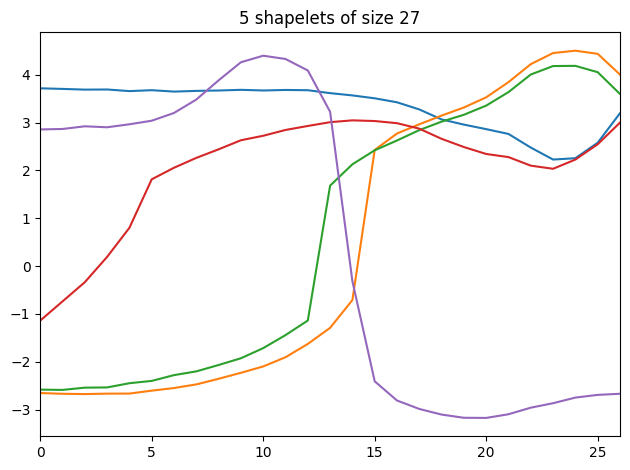

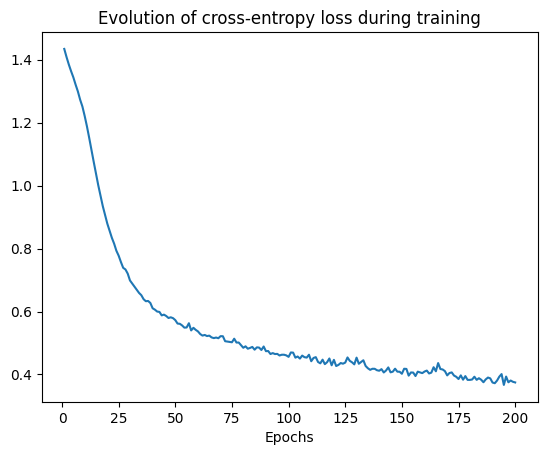

In [18]:


# Set seed for determinism
numpy.random.seed(0)

# Load the Trace dataset
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")

# Normalize each of the timeseries in the Trace dataset
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)
X_test = TimeSeriesScalerMinMax().fit_transform(X_test)

# Get statistics of the dataset
n_ts, ts_sz = X_train.shape[:2]
n_classes = len(set(y_train))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

# Define the model using parameters provided by the authors (except that we
# use fewer iterations here)
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(.01),
                            batch_size=16,
                            weight_regularizer=.01,
                            max_iter=200,
                            random_state=42,
                            verbose=0)
shp_clf.fit(X_train, y_train)

# Make predictions and calculate accuracy score
pred_labels = shp_clf.predict(X_test)
print("Correct classification rate:", accuracy_score(y_test, pred_labels))

# Plot the different discovered shapelets
plt.figure()
for i, sz in enumerate(shapelet_sizes.keys()):
    plt.subplot(len(shapelet_sizes), 1, i + 1)
    plt.title("%d shapelets of size %d" % (shapelet_sizes[sz], sz))
    for shp in shp_clf.shapelets_:
        if ts_size(shp) == sz:
            plt.plot(shp.ravel())
    plt.xlim([0, max(shapelet_sizes.keys()) - 1])

plt.tight_layout()
plt.show()

# The loss history is accessible via the `model_` that is a keras model
plt.figure()
plt.plot(numpy.arange(1, shp_clf.n_iter_ + 1), shp_clf.history_["loss"])
plt.title("Evolution of cross-entropy loss during training")
plt.xlabel("Epochs")
plt.show()

In [31]:
print(X_train.dtype)
print(X_train1.dtype)

float64
object
